### Exploratory Analysis of Spatial Data: Spatial Autocorrelation

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import esda
import libpysal as lps
import contextily as cx
import seaborn as sns

sns.set_context('notebook')
%matplotlib inline

In [3]:
scag = gpd.read_file('data/scipy/scag_region.gpkg')

In [5]:
san_diego = scag[scag.geoid.str[:5] == '06073']
san_diego.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 627 entries, 158 to 4567
Columns: 194 entries, geoid to geometry
dtypes: float64(172), geometry(1), int64(1), object(20)
memory usage: 955.2+ KB


In [6]:
# Remove rows without value for 'median_home_value'
san_diego = san_diego.dropna(subset=['median_home_value'])

In [7]:
san_diego = san_diego.to_crs(epsg=3857)

(-13099175.999157175,
 -12913655.059545828,
 3827188.049586127,
 3968975.9534278195)

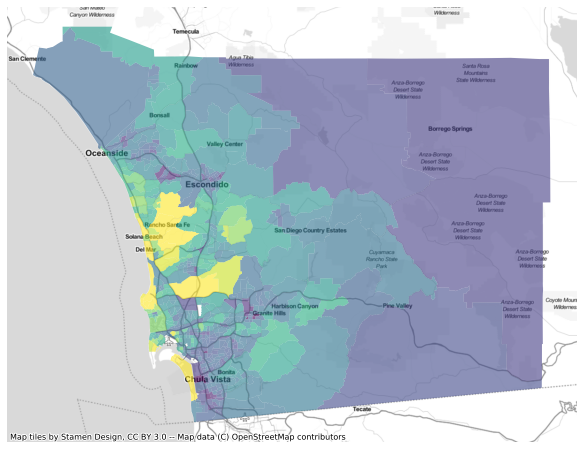

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 8))
san_diego.plot('median_home_value', ax=ax, alpha=0.6)
cx.add_basemap(ax=ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

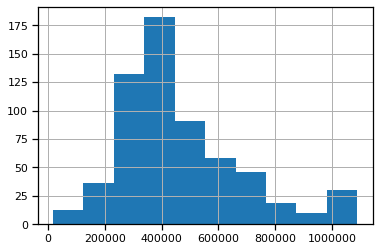

In [9]:
san_diego.median_home_value.hist()

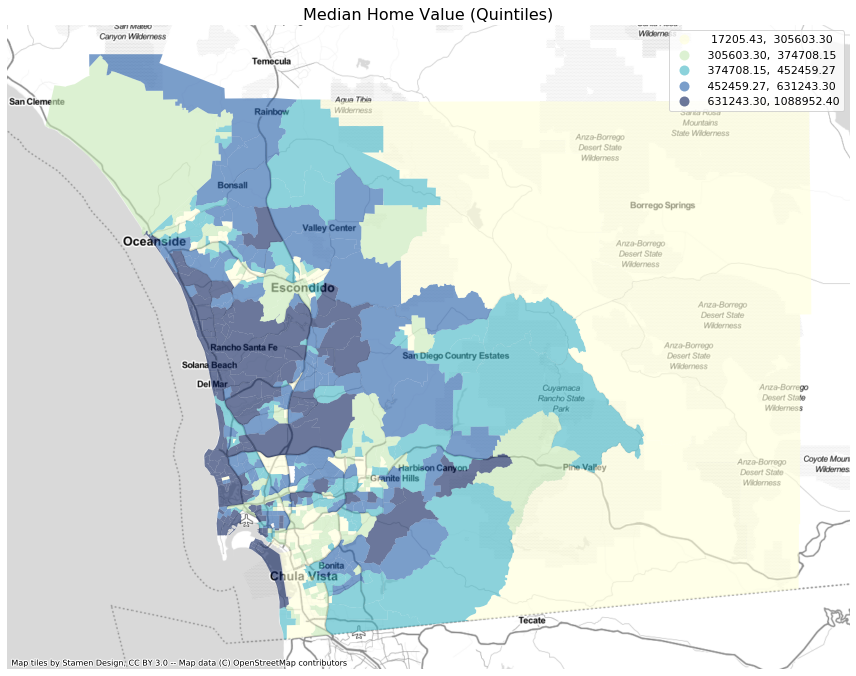

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
san_diego.plot('median_home_value', ax=ax, legend=True, scheme='Quantiles', alpha=0.6, cmap='YlGnBu')
cx.add_basemap(ax=ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

plt.title('Median Home Value (Quintiles)', fontsize=16)
plt.axis('off')
plt.tight_layout()

#### Spatial Similarity

In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of 
spatial similarity. In the following example, Queen contiguity is used:

In [21]:
queen = lps.weights.Queen.from_dataframe(san_diego)
queen.transform = 'r'

#### Attribute Similarity
Spatial weight attributes indicate whether polygons *i* and *j* are neighbors or not. Additionally, there's also need for a measure of attribute similarity. The **spatial lag** is a derived variable that accomplishes this.

In [28]:
y = san_diego['median_home_value']
spatial_lag = lps.weights.lag_spatial(queen, y)

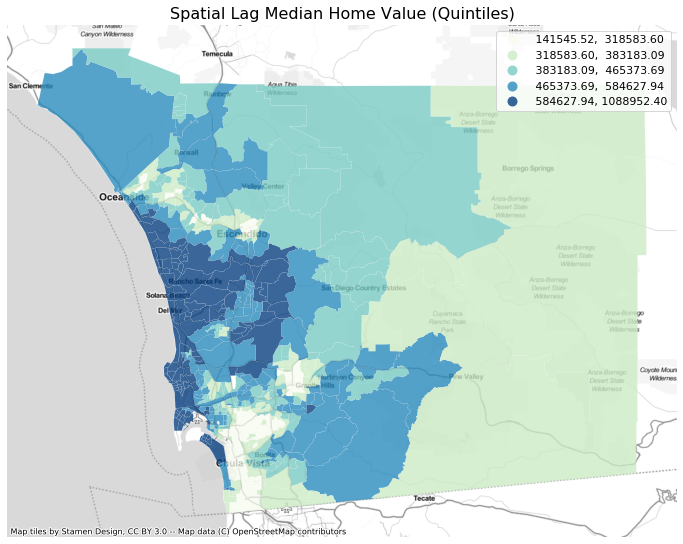

In [32]:
fig, ax = plt.subplots(1, figsize=(12, 12))

san_diego.assign(spatial_lag=spatial_lag).plot(column='spatial_lag', scheme='Quantiles', k=5, \
                              cmap='GnBu', linewidth=0.1, ax=ax, \
                              edgecolor='white', legend=True, alpha=0.8)

cx.add_basemap(ax, crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

plt.title('Spatial Lag Median Home Value (Quintiles)', fontsize=16)
plt.show()

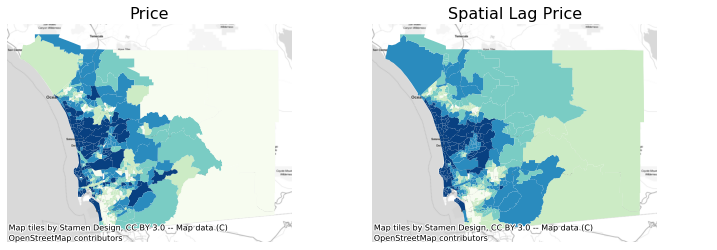

In [38]:
san_diego['lag_median_pri'] = spatial_lag

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))

san_diego.plot(ax=ax[0], column='median_home_value', scheme='Quantiles', k=5, cmap='GnBu')
ax[0].set_title('Price', fontsize=16)

san_diego.plot(ax=ax[1], column='lag_median_pri', scheme='Quantiles', k=5, cmap='GnBu')
ax[1].set_title('Spatial Lag Price', fontsize=16)

cx.add_basemap(ax[0], crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax[1], crs=san_diego.crs.to_string(), source=cx.providers.Stamen.TonerLite)

ax[0].axis('off')
ax[1].axis('off')

plt.show()

### Global Spatial Autocorrelation

#### Join counts

In [42]:
y.median() # median home value 

403347.5655430712

In [43]:
san_diego.shape

(617, 195)

In [44]:
yb = y > y.median()
sum(yb)

308

In [45]:
yb = y > y.median()
labels = ['0 Low', '1 High']
yb = [labels[i] for i in 1*yb] # 1 * yb returns either 0 or 1
san_diego['yb'] = yb

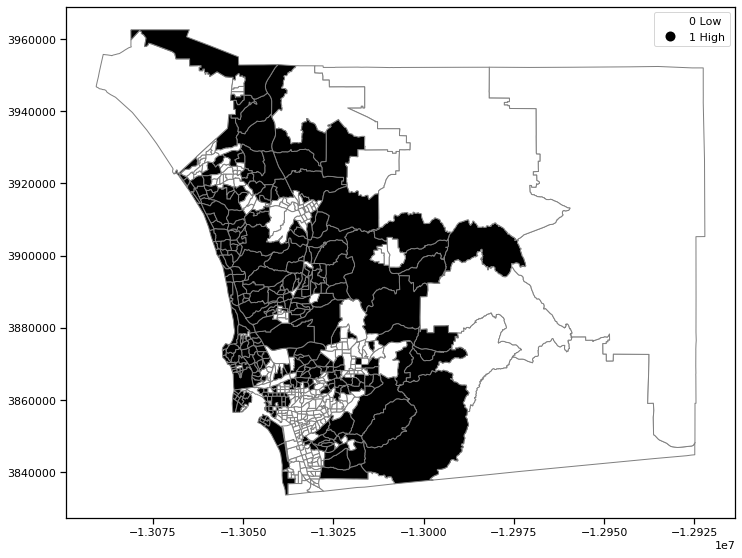

In [46]:
fig, ax = plt.subplots(figsize=(12, 12))
san_diego.plot(column='yb', cmap='binary', edgecolor= 'grey', legend=True, ax=ax)

Given that there are 308 Black Polygons - representing neighborhoods where home values is above the median - on the map, what is the number of possible Black Black (BB, a Black polygon surrounded by Black polygons) joins if the process where such that the Black polygons were randomly assigned to the map?

In [47]:
yb = 1 * (y > y.median()) # zeros and ones
queen = lps.weights.Queen.from_dataframe(san_diego)
queen.transform = 'b'
np.random.seed(12345)
join_count = esda.join_counts.Join_Counts(yb, queen)

In [49]:
join_count.bb # BB, Black Black polygons

736.0

In [50]:
join_count.ww # WW, White White polygons

724.0

In [51]:
join_count.bw # BW, Black White polygons

467.0

In [52]:
join_count.bb + join_count.ww + join_count.bw

1927.0

In [53]:
join_count.mean_bb

478.83983983983984

Text(0.5, 0, 'BB Counts')

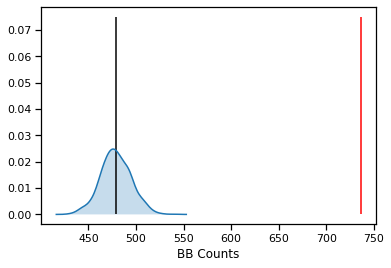

In [56]:
sns.kdeplot(join_count.sim_bb, shade=True)
plt.vlines(join_count.bb, 0, 0.075, color='r')
plt.vlines(join_count.mean_bb, 0, 0.075)
plt.xlabel('BB Counts')

#### Continuous Case

In [58]:
queen.transform = 'r'

y = san_diego['median_home_value']

Moran I: statistic that measures the correlation between a focal point and it's neighbors

In [60]:
np.random.seed(12345)
moran_i = esda.moran.Moran(y, queen)
moran_i.I

0.6798091424192116

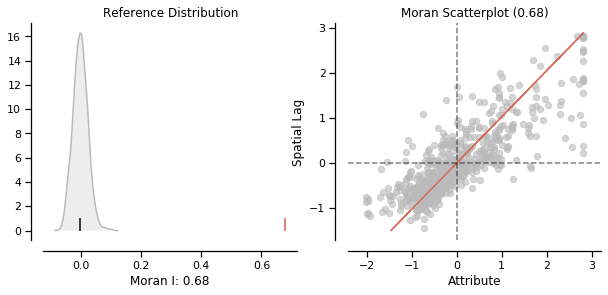

In [62]:
from splot.esda import plot_moran
plot_moran(moran_i, zstandard=True, figsize=(10, 4))
plt.show()

In [64]:
moran_i.p_sim

0.001